# Microsoft Movie Analysis Project

## Project Summary

## Data Exploration & Prep


### Import Libraries


In [104]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set display options to remove scientific notation and allow dataframe rows to display
pd.options.display.float_format = '{:,.1f}'.format
pd.set_option("max_rows", None)

### Source Data Loads

In [125]:
# Load IMDB Basics as title master, set index and convert minutes from float
imdb_basics = pd.read_csv('data/imdb.title.basics.csv')
imdb_basics['runtime_minutes'] = imdb_basics['runtime_minutes'].astype('Int64')

# Load IMDB Ratings, set index, standarized column names and convert votes to integer
imdb_ratings = pd.read_csv('data/imdb.title.ratings.csv')
imdb_ratings.rename(columns={'averagerating': "avg_rating", 'numvotes': 'num_votes'}, inplace=True)
imdb_ratings['num_votes'] = imdb_ratings['num_votes'].astype('Int64')

# Load BOM Movie Gross, transform gross columns from mixed data types into integer
bom = pd.read_csv('data/bom.movie_gross.csv')
bom['domestic_gross'].replace('"', '', inplace=True)
bom['domestic_gross'].fillna(0, inplace=True)
bom['domestic_gross'] = bom['domestic_gross'].astype('Int64')
bom['foreign_gross'] = bom['foreign_gross'].str.replace(',', '')
bom['foreign_gross'].fillna(0, inplace=True)
bom['foreign_gross'] = bom['foreign_gross'].astype('float').round(0).astype('Int64')


### Data Profiling

#### IMDB Basics File

In [3]:
# IMDB Basics import and data quality check

print(imdb_basics.head(2))
imdb_basics.info() # Nulls 31K minutes, 5K genre
imdb_basics.duplicated(['tconst'],keep=False).sum() #No dups
imdb_basics.duplicated(['primary_title','start_year'],keep=False).sum() #3942 dups
imdb_basics['start_year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
imdb_basics['genres'].value_counts(sort=True) #Majority single genres but 1085 combinations

      tconst                    primary_title   original_title  start_year  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   runtime_minutes              genres  
0            175.0  Action,Crime,Drama  
1            114.0     Biography,Drama  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Documentary                  32185
Drama                        21486
Comedy                        9177
Horror                        4372
Comedy,Drama                  3519
                             ...  
Mystery,News,Thriller            1
Family,History,Romance           1
History,News,War                 1
Animation,Music,Thriller         1
Biography,Fantasy,History        1
Name: genres, Length: 1085, dtype: int64

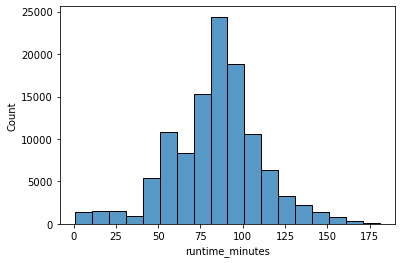

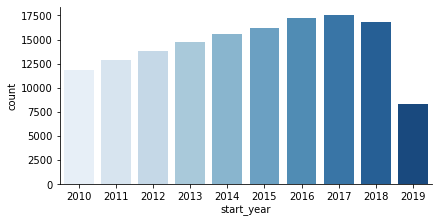

In [163]:
# Review distribution plots
length180 = imdb_basics[imdb_basics['runtime_minutes'] < 180]
sns.histplot(data=length180, x='runtime_minutes', binwidth=10, palette='Blues')

keepyears = imdb_basics[imdb_basics['start_year'].between(2010,2019)]
sns.catplot(data=keepyears, kind='count', x='start_year', palette='Blues', height=3, aspect=2)


In [141]:
movies['start_year'].value_counts()

2017    17505
2016    17272
2018    16849
2015    16243
2014    15589
2013    14709
2012    13788
2011    12900
2010    11849
2019     8379
2020      937
2021       83
2022       32
2023        5
2024        2
2027        1
2026        1
2025        1
2115        1
Name: start_year, dtype: int64

#### BOM Movie Gross File

In [97]:
# BOM Movie Gross File - explore data quality
print(bom_movie_gross.head(2))
print(bom_movie_gross.info()) # Nulls 31K minutes, 5K genre
print(f"\n**{bom_movie_gross.duplicated(['title'],keep=False).sum()} duplicates found based on title**\n") #No dups
print(bom_movie_gross.describe())
bom_movie_gross['year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
bom_movie_gross['studio'].value_counts(sort=True) #Majority single genres but 1085 combinations

                        title studio  domestic_gross foreign_gross  year
0                 Toy Story 3     BV       415000000     652000000  2010
1  Alice in Wonderland (2010)     BV       334200000     691300000  2010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           3387 non-null   object
 1   studio          3382 non-null   object
 2   domestic_gross  3359 non-null   Int64 
 3   foreign_gross   2037 non-null   object
 4   year            3387 non-null   int64 
dtypes: Int64(1), int64(1), object(3)
memory usage: 135.7+ KB

**2 duplicates found based on title**

         domestic_gross        year
count       3,359.00000 3,387.00000
mean   28,745,845.06698 2,013.95807
std    66,982,498.23736     2.47814
min           100.00000 2,010.00000
25%       120,000.00000 2,012.00000
50%     1,400,000.00000 2,014.00000
75%    27,900

IFC         166
Uni.        147
WB          140
Magn.       136
Fox         136
           ... 
Viv.          1
Proud         1
Gaum.         1
GrtIndia      1
BSC           1
Name: studio, Length: 257, dtype: int64

## Feature Engineering

### Extend IMDB Basics with Ratings 

In [126]:
# Create Movies DF - basics left join to ratings and bom 
movies = imdb_basics.merge(imdb_ratings, how='left', left_on='tconst', right_on='tconst', indicator='rating_ind')
movies.drop(columns=['original_title'], inplace=True)

movies = movies.merge(bom, how='left', left_on='primary_title', right_on='title', indicator='gross_ind')
movies.drop(columns=['title','year'], inplace=True)

movies.head(100)

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,studio,domestic_gross,foreign_gross,gross_ind
0,tt0063540,Sunghursh,2013,175,"Action,Crime,Drama",7.0,77,both,NaN,<NA>,<NA>,left_only
1,tt0066787,One Day Before the Rainy Season,2019,114,"Biography,Drama",7.2,43,both,NaN,<NA>,<NA>,left_only
2,tt0069049,The Other Side of the Wind,2018,122,Drama,6.9,4517,both,NaN,<NA>,<NA>,left_only
3,tt0069204,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama",6.1,13,both,NaN,<NA>,<NA>,left_only
4,tt0100275,The Wandering Soap Opera,2017,80,"Comedy,Drama,Fantasy",6.5,119,both,NaN,<NA>,<NA>,left_only
5,tt0111414,A Thin Life,2018,75,Comedy,nan,<NA>,left_only,NaN,<NA>,<NA>,left_only
6,tt0112502,Bigfoot,2017,<NA>,"Horror,Thriller",4.1,32,both,NaN,<NA>,<NA>,left_only
7,tt0137204,Joe Finds Grace,2017,83,"Adventure,Animation,Comedy",8.1,263,both,NaN,<NA>,<NA>,left_only
8,tt0139613,O Silêncio,2012,<NA>,"Documentary,History",nan,<NA>,left_only,NaN,<NA>,<NA>,left_only
9,tt0144449,Nema aviona za Zagreb,2012,82,Biography,nan,<NA>,left_only,NaN,<NA>,<NA>,left_only


In [134]:
movies.groupby(['rating_ind','gross_ind']).size() # 98% have ratings, less than 5% have gross sales


rating_ind  gross_ind 
left_only   left_only     71949
            right_only        0
            both            339
right_only  left_only         0
            right_only        0
            both              0
both        left_only     70831
            right_only        0
            both           3027
dtype: int64

### IMDB Basics Genre

In [32]:
# Concatenate non-null genres series strings together in unique list
genres_list = ','.join(str(x) for x in imdb_basics['genres'].dropna().unique())
# Split genres list into unique set of genres
genres_unique = set(x for x in genres_list.split(','))

# Loop unique genres, create new boolean series for each genre; useful for correlations
for genre in sorted(genres_unique):
    imdb_basics['is_'+genre.lower()] = imdb_basics.apply(lambda x: int(genre in str(x.genres)), axis=1)

imdb_basics.head(50)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,is_action,is_adult,is_adventure,is_animation,...,is_news,is_reality-tv,is_romance,is_sci-fi,is_short,is_sport,is_talk-show,is_thriller,is_war,is_western
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller",0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### IMDB Ratings

In [34]:

imdb_ratings.head()
imdb_ratings.info()
imdb_ratings.duplicated(['tconst'],keep=False).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


0

## Deprecated Code

In [110]:
# IMDB Basics parse and featurize genres
def match_genre(target_genre, title_genres):
    result = 0
    if title_genres: 
        for genre in title_genres:
            if genre == target_genre: 
                result += 1
            else:     
                result += 0
    if result > 0: result = 1
    return result

unique_genres = sorted(imdb_basics['genres'].str.split(pat=",").explode().dropna().unique())
genre_series = imdb_basics['genres'].str.split(pat=",")

for key, genre in genre_series.head(50).items():
    for g in unique_genres:
        match = match_genre(g, genre)
        #print(genre, g, match)
        genre_series[key][g] = match #old method, had error on this line otherwise function working

imdb_basics.head(50)

TypeError: list indices must be integers or slices, not str